# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
import math
import joblib
import random


# 2. Data Visualisation, Preprocessing, and Feature Engineering

In [2]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


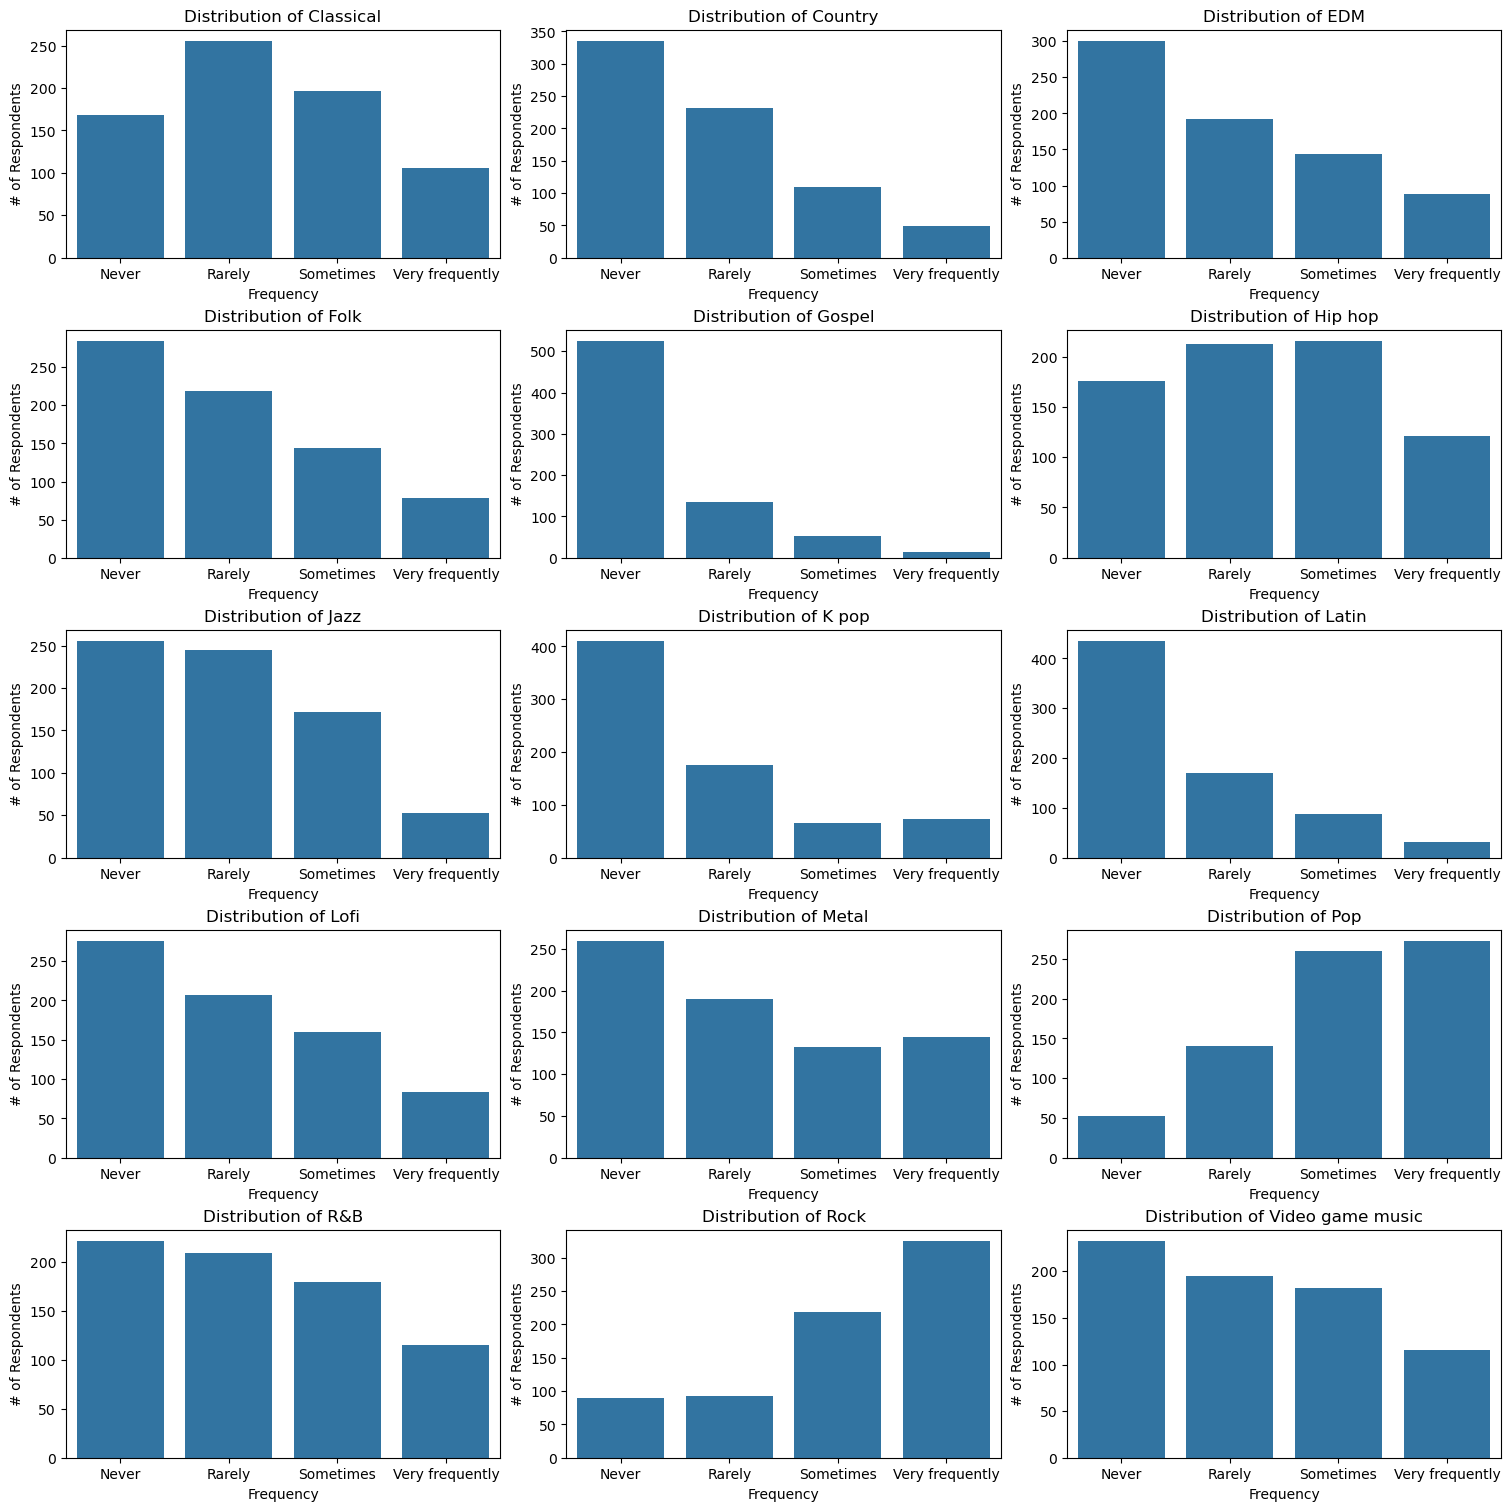

In [12]:
# Plot the distribution of each genre frequency in a grid
genre = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in genre:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [ ]:
# Drop gospel and latin, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]', 'Frequency [Latin]'])

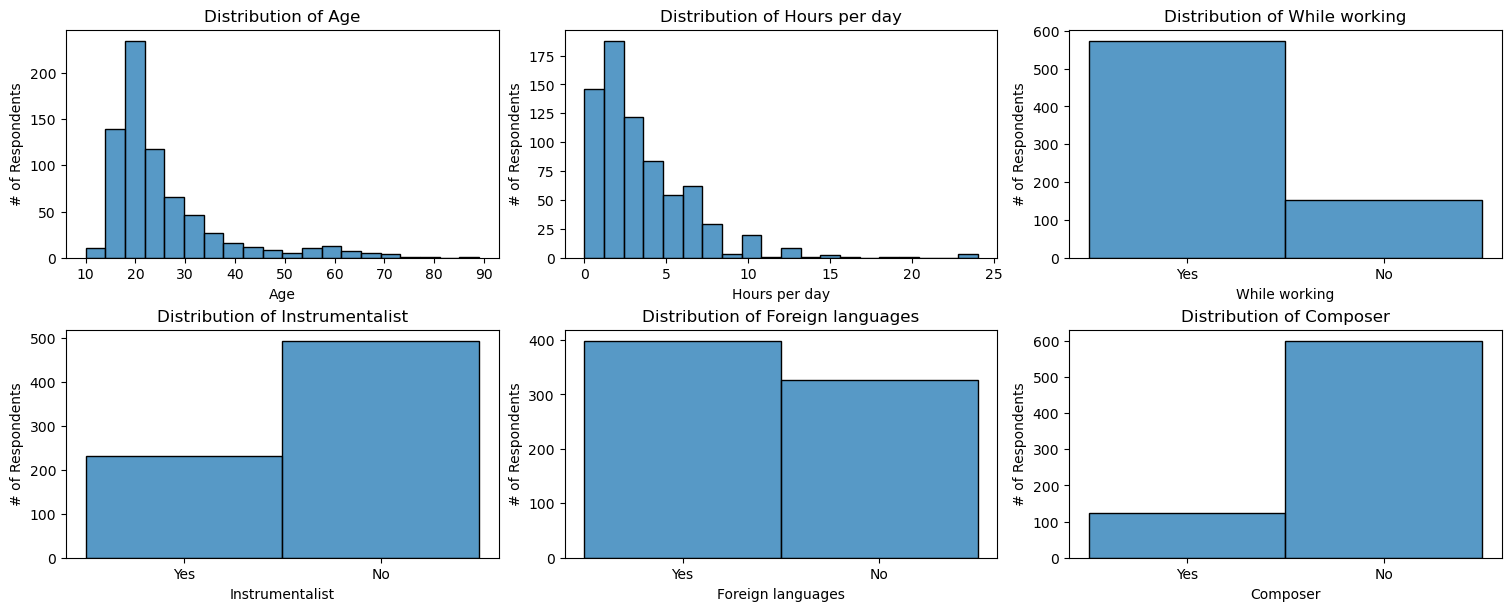

In [4]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

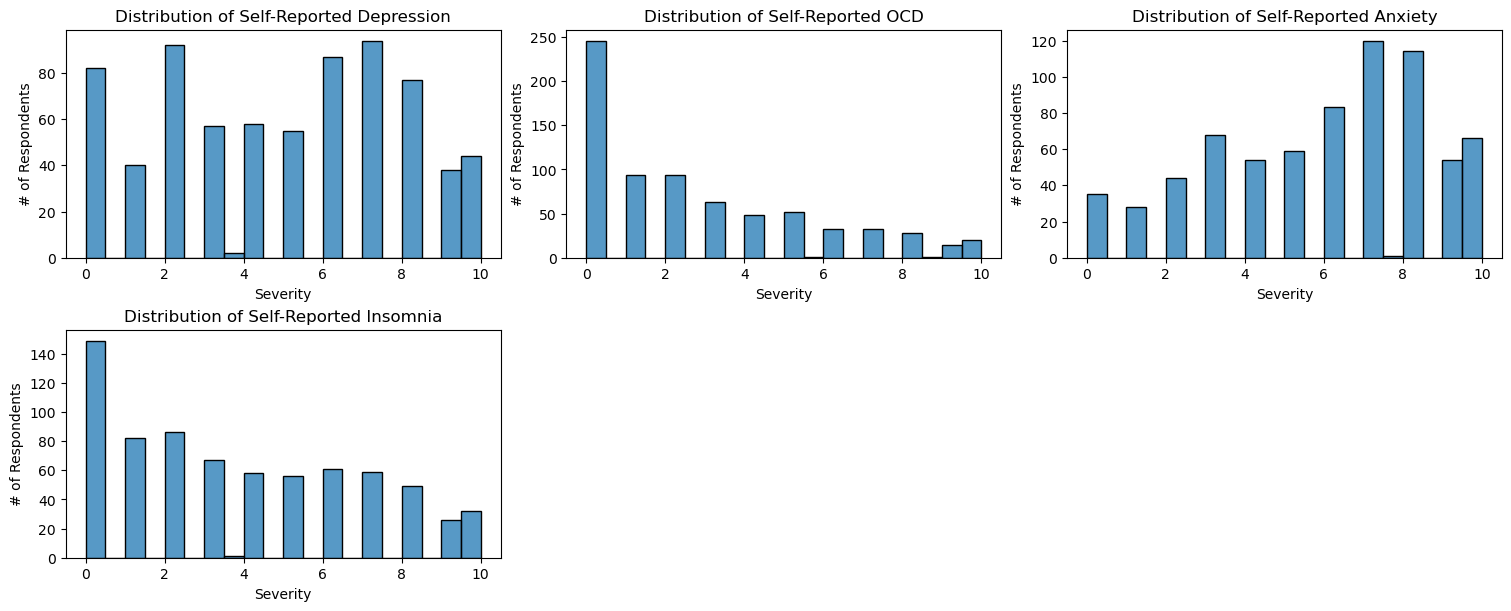

In [5]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [9]:
# Display summary statistics of the dataset
df.describe()

,Age,Hours per day,Anxiety_class,Depression_class,Insomnia_class,OCD_class
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,25.241047,3.564807,1.247934,0.975207,0.699725,0.446281
std,12.081723,3.006324,0.818217,0.849790,0.817515,0.713810
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,21.000000,3.000000,1.000000,1.000000,0.000000,0.000000
75%,28.000000,5.000000,2.000000,2.000000,1.000000,1.000000
max,89.000000,24.000000,2.000000,2.000000,2.000000,2.000000


In [6]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [7]:
# Convert favourite genre into a boost applied to the users favourite genre frequency

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

fav_genre_boost = 1.0   # Boost amount 1.0 to add to favourite genre frequency

# Convert favourite genre into frequency column name
def convert_fav_genre_to_freq_col(genre):
    return f"Frequency [{genre}]"

# Apply boost to favourite genre frequency
for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + fav_genre_boost

# Drop original Fav genre column 
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [8]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# Identify Yes/No columns
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

# Conver true false to binary 1/0
for col in df_fe1.columns:
    if df_fe1[col].dtype == bool:
        df_fe1[col] = df_fe1[col].astype(int)

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe

# Save the final preprocessed dataframe to a new CSV file
processed_data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df_fe1.to_csv(processed_data_path, index=False)

# Print message to confirm saving
print(f"Processed data saved to {processed_data_path}")


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']
Processed data saved to c:\Users\hanna\Documents\DS3000\DS3000-Group-4\Data\mxmh_survey_results_processed.csv


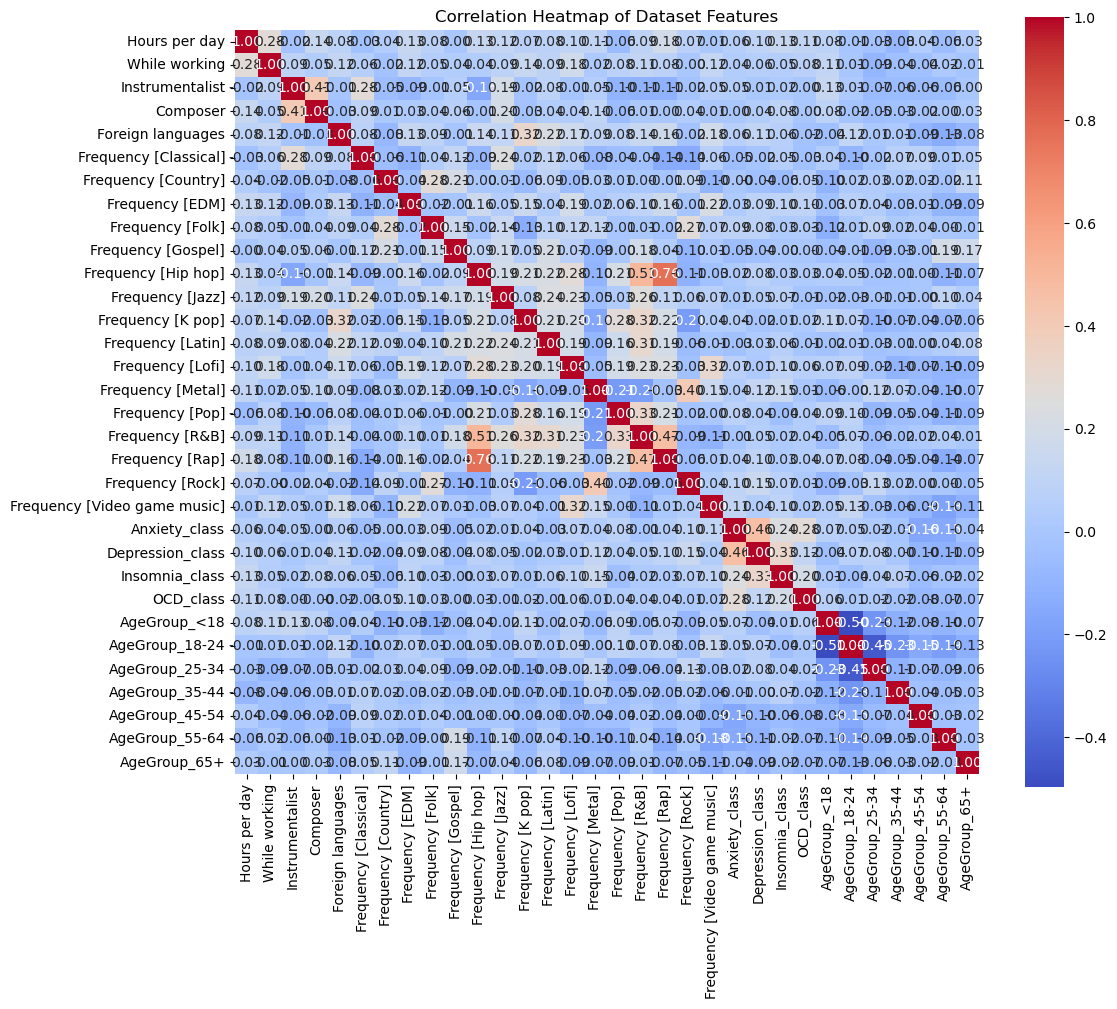

In [ ]:
# Create a correlation heatmap for the dataset

# Drop any one-hot encoded AgeGroup columns so the matrix excludes age bins
age_cols = [c for c in df_fe1.columns if str(c).startswith('AgeGroup')]
if age_cols:
    corr_df = df_fe1.drop(columns=age_cols)
else:
    corr_df = df_fe1

corr = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Dataset Features (age columns removed)")
plt.show()

# XGBoost Experiment